In [0]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2 

In [0]:
annFile='drive/My Drive/COCO/instances_train2017.json'

In [0]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=22.50s)
creating index...
index created!


In [0]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
cat_temp= nms
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory vehicle food furniture person kitchen sports outdoor indoor electronic animal appliance


In [0]:
#bear 1, elephant 2, giraffe 3, zebra 4, other 5
other_cat=['bird','cat','dog','horse','sheep','cow','kite','wine glass','cup','banana','apple','chair','laptop','mouse','remote', 'keyboard', 'cell phone',]

In [0]:
cat1to4= {'elephant', 'bear', 'giraffe', 'zebra'}

In [0]:
animal= []
target= []
for cat in cat1to4:
  catIds = coco.getCatIds(catNms=cat);
  imgIds = coco.getImgIds(catIds=catIds );
  for i in range(0,20):
      img = coco.loadImgs(imgIds[i])[0]
      I = io.imread(img['coco_url'])
      I1= cv2.resize(I,(128,128),interpolation = cv2.INTER_NEAREST)
      animal.append(I1)
      target.append(cat)

In [0]:
import random 
for i in range(20):
  n= random.randint(0,len(other_cat)-1)
  cat= other_cat[n]
  catIds = coco.getCatIds(catNms=cat);
  imgIds = coco.getImgIds(catIds=catIds );
  img = coco.loadImgs(imgIds[i])[0]
  I = io.imread(img['coco_url'])
  I1= cv2.resize(I,(128,128),interpolation = cv2.INTER_NEAREST)
  animal.append(I1)
  target.append('other')

In [0]:
X= animal
Y= target
for i in range(len(X)):
  x= animal[i].shape
  s=0
  for j in x:
    s= s+j;
  if(s==256):
    del X[i]
    del Y[i]

In [0]:
print(len(X))
print(len(Y))

100
100


 cat=  zebra
shape  (128, 128, 3)


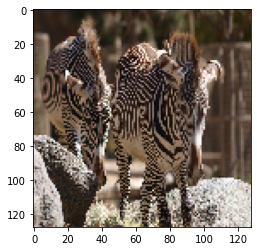

In [0]:
n= random.randint(0, len(target))
I= animal[n]
plt.imshow(I)
print(" cat= ", target[n] )
print("shape " , animal[n].shape)

In [0]:
imdata =np.vstack(X)
imdata= imdata.reshape(-1,128,128, 3)
target= Y

In [0]:
imdata.shape

(100, 128, 128, 3)

In [0]:
y= np.zeros([len(target),5],dtype= int)

In [0]:
#one hot  encoding
for i in range(len(target)):
  if target[i]=='elephant':
    y[i][1]= 1
  elif target[i]== 'bear':
    y[i][0]=1
  elif target[i]=='giraffe':
    y[i][2]= 1
  elif target[i]=='zebra':
    y[i][3]=1
  else:
    y[i][4]= 1

In [0]:
y[10]

array([1, 0, 0, 0, 0])

 cat=  [1 0 0 0 0]


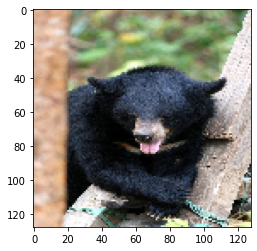

In [0]:
n= random.randint(0, len(target))
I= animal[n]
plt.imshow(I)
print(" cat= ", y[n] )

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imdata, y, test_size = 0.2, random_state =0)

In [0]:
import argparse

# Import necessary components to build LeNet
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
def coco_model(img_shape=(128, 128, 3), n_classes=5, l2_reg=0.,
	weights=None):

	# Initialize model
	model = Sequential()

	# Layer 1
	model.add(Conv2D(96, (7, 7), input_shape=img_shape,padding='valid', kernel_regularizer=l2(l2_reg)))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	model.add(Conv2D(256, (5, 5), padding='valid'))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	model.add(Conv2D(512, (3, 3), padding='valid'))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	model.add(Conv2D(1024, (3, 3), padding='same'))
	model.add(BatchNormalization())
	model.add(Activation('relu'))

	# Layer 5
	model.add(Conv2D(1024, (3, 3), padding='same'))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
 
  # Layer 6
	model.add(Conv2D(1024, (3, 3), padding='valid'))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

  # Layer 7
	model.add(Flatten())
	model.add(Dense(3072))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Dropout(0.5))

  # Layer 8
	model.add(Dense(1024))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Dropout(0.5))

	# Layer 9
	model.add(Dense(n_classes))
	model.add(BatchNormalization())
	model.add(Activation('softmax'))

	if weights is not None:
		model.load_weights(weights)

	return model

In [0]:
model = coco_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 122, 122, 96)      14208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 122, 96)      384       
_________________________________________________________________
activation_1 (Activation)    (None, 122, 122, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 57, 57, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 57, 256)      

In [0]:
import keras
opt= keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= 'sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
X_train = X_train/255.
X_test = X_test/255.

In [0]:
model.fit(X_train, y_train, epochs = 10, batch_size = 20)

Epoch 1/25
80/80 [==============================] - 3s 40ms/step - loss: 0.3959 - accuracy: 0.9750
Epoch 2/25
80/80 [==============================] - 1s 18ms/step - loss: 0.3781 - accuracy: 0.9500
Epoch 3/25
80/80 [==============================] - 1s 18ms/step - loss: 0.4043 - accuracy: 0.9750
Epoch 4/25
80/80 [==============================] - 1s 18ms/step - loss: 0.3319 - accuracy: 1.0000
Epoch 5/25
80/80 [==============================] - 1s 19ms/step - loss: 0.3588 - accuracy: 0.9875
Epoch 6/25
80/80 [==============================] - 1s 19ms/step - loss: 0.3832 - accuracy: 0.9875
Epoch 7/25
80/80 [==============================] - 1s 19ms/step - loss: 0.3546 - accuracy: 0.9875
Epoch 8/25
80/80 [==============================] - 1s 19ms/step - loss: 0.3142 - accuracy: 0.9875
Epoch 9/25
80/80 [==============================] - 1s 19ms/step - loss: 0.3511 - accuracy: 0.9750
Epoch 10/25
80/80 [==============================] - 1s 18ms/step - loss: 0.3242 - accuracy: 0.9875
Epoch 11/

In [0]:
Y_predicted= model.predict(X_test)

cat_predicted=  [0.11587928 0.19352546 0.10511322 0.42815015 0.15733194]
cat_actual=  [0 0 0 1 0]


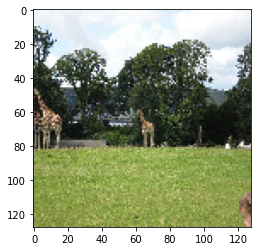

cat_predicted=  [0.09286249 0.07481548 0.06663015 0.68473804 0.0809539 ]
cat_actual=  [0 1 0 0 0]


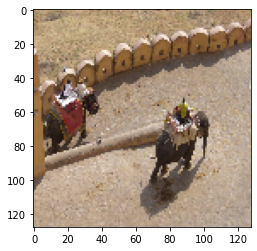

cat_predicted=  [0.11535791 0.06777012 0.06499025 0.6797841  0.07209761]
cat_actual=  [1 0 0 0 0]


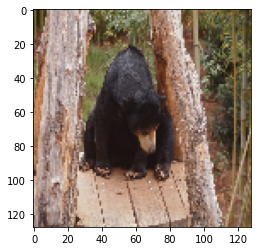

cat_predicted=  [0.13263276 0.07245978 0.07304864 0.654675   0.06718381]
cat_actual=  [0 1 0 0 0]


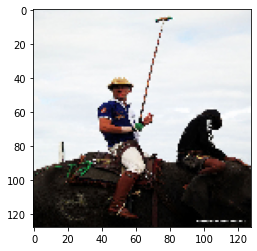

cat_predicted=  [0.18986376 0.09844334 0.09680688 0.55404246 0.06084358]
cat_actual=  [0 0 0 1 0]


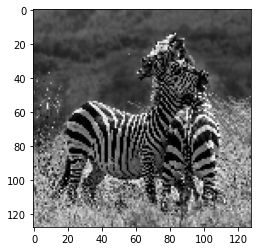

cat_predicted=  [0.07716852 0.05609842 0.05522569 0.75337476 0.05813267]
cat_actual=  [0 0 0 1 0]


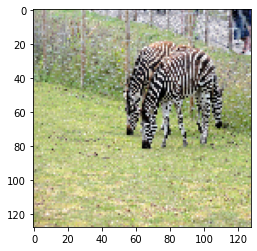

cat_predicted=  [0.15987651 0.09170277 0.079764   0.58991814 0.07873856]
cat_actual=  [1 0 0 0 0]


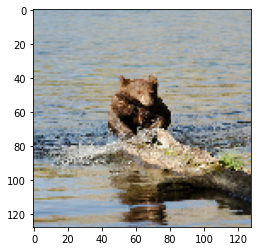

cat_predicted=  [0.35511267 0.11399047 0.08768197 0.31151444 0.13170043]
cat_actual=  [0 0 0 0 1]


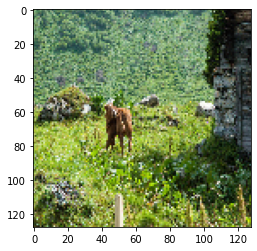

cat_predicted=  [0.286782   0.0845241  0.07490446 0.42835632 0.12543313]
cat_actual=  [0 0 0 0 1]


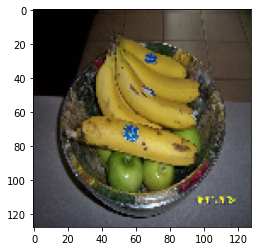

cat_predicted=  [0.12394614 0.06071419 0.06557754 0.64642054 0.10334162]
cat_actual=  [0 1 0 0 0]


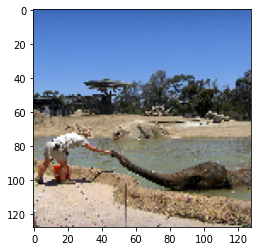

cat_predicted=  [0.12969823 0.074966   0.07096535 0.65872467 0.06564579]
cat_actual=  [0 1 0 0 0]


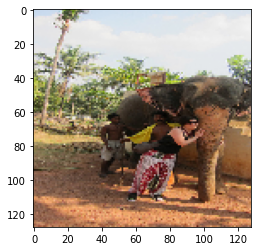

cat_predicted=  [0.21041547 0.10010882 0.08549195 0.49892828 0.1050554 ]
cat_actual=  [0 0 0 0 1]


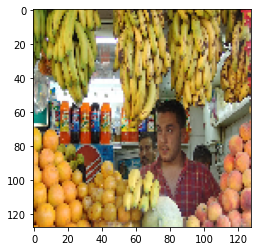

cat_predicted=  [0.13673612 0.08182874 0.07866172 0.63217145 0.07060195]
cat_actual=  [0 0 0 0 1]


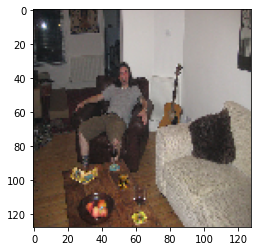

cat_predicted=  [0.20020813 0.06986856 0.07817756 0.56185156 0.08989423]
cat_actual=  [0 1 0 0 0]


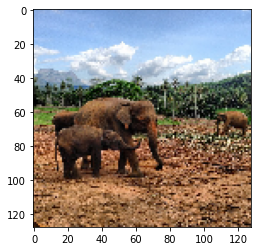

cat_predicted=  [0.13008541 0.0785799  0.07473949 0.6684811  0.0481141 ]
cat_actual=  [0 0 0 1 0]


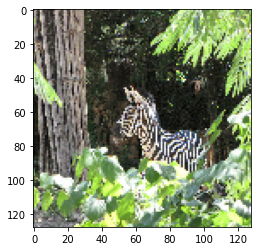

cat_predicted=  [0.12919897 0.07284455 0.07222664 0.6752154  0.05051439]
cat_actual=  [0 0 1 0 0]


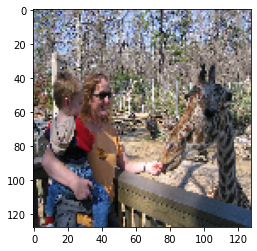

cat_predicted=  [0.10028886 0.05730096 0.06709107 0.7182669  0.0570522 ]
cat_actual=  [1 0 0 0 0]


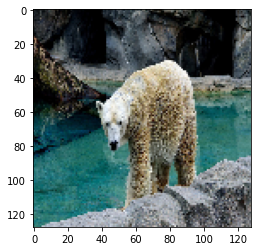

cat_predicted=  [0.45149687 0.08493134 0.0876774  0.29130435 0.08459002]
cat_actual=  [0 0 0 1 0]


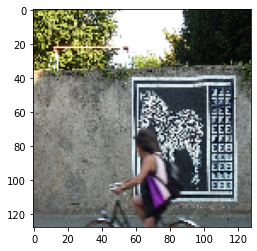

cat_predicted=  [0.11298901 0.0745096  0.07177795 0.61564094 0.12508245]
cat_actual=  [0 1 0 0 0]


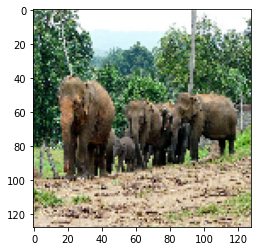

cat_predicted=  [0.3677468  0.24023725 0.07483544 0.24114436 0.07603617]
cat_actual=  [0 1 0 0 0]


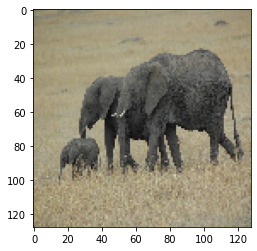

In [0]:
for i in range(20):
  plt.imshow(X_train[i])
  print("cat_predicted= ",Y_predicted[i])
  print("cat_actual= ", y_train[i])
  plt.show()